##**NON GRADED CHALLENGE 1**

##**BY : M RIZKI HERFIAN**

##**MATERI : Training Optimization**

##**STEP 1 : IMPORT LIBRARY**

In [1]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 98 kB 3.3 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
import sklearn
import tensorflow as tf
import keras_tuner as kt


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from tensorflow.keras import initializers, optimizers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.wrappers import scikit_learn
from keras.callbacks import EarlyStopping
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [3]:
# def convert_to_gray(inp_data):
#     inp_data = tf.squeeze(tf.image.rgb_to_grayscale(inp_data))
#     return inp_data

def extract_data(X_data, y_data, id_class):
    idx = np.where(y_data == [id_class])[0]
    x = X_data[idx, :]
    return x

## **STEP 2 : LOAD MNIST DATASET**

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
X_train = X_train[..., np.newaxis]/255.0
X_test = X_test[..., np.newaxis]/255.0

In [6]:
X_train.shape

(60000, 28, 28, 1)

In [7]:
print("Train set")
print(f"Unique Class: {pd.Series(y_train).nunique()}")
print(f"Class type: {sorted(pd.Series(y_train).unique().tolist())}")
print(f"Counts:\n{pd.Series(y_train).value_counts()}")

print("\nTest set")
print(f"Unique Class: {pd.Series(y_test).nunique()}")
print(f"Class type: {sorted(pd.Series(y_test).unique().tolist())}")
print(f"Counts:\n{pd.Series(y_test).value_counts()}")

Train set
Unique Class: 10
Class type: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Counts:
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64

Test set
Unique Class: 10
Class type: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Counts:
1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
dtype: int64


In [8]:
# extract data train class 1, 3, 7
X_train_1 = extract_data(X_train, y_train, 1)
X_train_3 = extract_data(X_train, y_train, 3)
X_train_7 = extract_data(X_train, y_train, 7)

# extract data train class 1, 3, 7
y_train_1 = tf.ones(X_train_1.shape[0])*0
y_train_3 = tf.ones(X_train_3.shape[0])*1
y_train_7 = tf.ones(X_train_7.shape[0])*2

X_train_full = tf.concat([X_train_1, X_train_3, X_train_7], 0)
y_train_full = tf.concat([y_train_1, y_train_3, y_train_7], 0)

In [9]:
pd.Series(y_train_full).value_counts()

0.0    6742
2.0    6265
1.0    6131
dtype: int64

In [10]:
# extract data test class 1, 3, 7
X_test_1 = extract_data(X_test, y_test, 1)
X_test_3 = extract_data(X_test, y_test, 3)
X_test_7 = extract_data(X_test, y_test, 7)

# extract data test class 1, 3, 7
y_test_1 = tf.ones(X_test_1.shape[0])*0
y_test_3 = tf.ones(X_test_3.shape[0])*1
y_test_7 = tf.ones(X_test_7.shape[0])*2

X_test = tf.concat([X_test_1, X_test_3, X_test_7], 0)
y_test = tf.concat([y_test_1, y_test_3, y_test_7], 0)

##**STEP 3 : SPLIT DATASET**

In [11]:
tf.keras.backend.clear_session()
np.random.seed(77)
tf.random.set_seed(77)

In [12]:
idx_rnd = np.random.permutation(len(X_train_full))

idx_train = idx_rnd[0:int(len(X_train_full)*0.7)]
idx_val = idx_rnd[int(len(X_train_full)*0.7):]

X_train = tf.gather(X_train_full, idx_train)
X_val = tf.gather(X_train_full, idx_val)

y_train = tf.gather(y_train_full, idx_train)
y_val = tf.gather(y_train_full, idx_val)

In [13]:
X_train.shape

TensorShape([13396, 28, 28, 1])

## **STEP 4 : LeNet Network**

In [14]:
def lenet_network(weight_init=initializers.GlorotNormal(), conv_act_func='relu'):
    model = Sequential([
        Conv2D(32, [3, 3], activation=conv_act_func, kernel_initializer=weight_init, input_shape=(28, 28, 1)),
        # Conv2D(64, [3, 3], activation=hidden_act_func, kernel_initializer=weight_init),
        MaxPooling2D(pool_size = (2, 2)),
        # Dropout(0.25),
        Flatten(),
        # Dense(128, activation='relu', kernel_initializer=weight_init),
        Dense(64, activation='relu', kernel_initializer=weight_init),
        # Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    
    return model

## **STEP 5 : INITIALIZER**

In [15]:
initializer_history = {}

###**Glorot**

In [16]:
tf.keras.backend.clear_session()
np.random.seed(77)
tf.random.set_seed(77)

In [17]:
glorot_model = lenet_network(weight_init=initializers.GlorotNormal())

glorot_model.compile(
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

glorot_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 64)                346176    
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 346,691
Trainable params: 346,691
Non-trainable params: 0
__________________________________________________

In [18]:
initializer_history['Glorot Normal'] = glorot_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10).history

Epoch 1/10
419/419 [==============================] - 10s 22ms/step - loss: 0.0628 - accuracy: 0.9802 - val_loss: 0.0664 - val_accuracy: 0.9828
Epoch 2/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0244 - accuracy: 0.9928 - val_loss: 0.0295 - val_accuracy: 0.9920
Epoch 3/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0144 - accuracy: 0.9954 - val_loss: 0.0298 - val_accuracy: 0.9936
Epoch 4/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0112 - accuracy: 0.9968 - val_loss: 0.0290 - val_accuracy: 0.9934
Epoch 5/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0077 - accuracy: 0.9979 - val_loss: 0.0331 - val_accuracy: 0.9934
Epoch 6/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0067 - accuracy: 0.9984 - val_loss: 0.0280 - val_accuracy: 0.9939
Epoch 7/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0324 - val_accuracy: 0.994

###**He**

In [19]:
tf.keras.backend.clear_session()
np.random.seed(77)
tf.random.set_seed(77)

In [20]:
he_model = lenet_network(weight_init=initializers.HeNormal())

he_model.compile(
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

he_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 64)                346176    
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 346,691
Trainable params: 346,691
Non-trainable params: 0
__________________________________________________

In [21]:
initializer_history['He Normal'] = he_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10).history

Epoch 1/10
419/419 [==============================] - 10s 22ms/step - loss: 0.0582 - accuracy: 0.9794 - val_loss: 0.0642 - val_accuracy: 0.9855
Epoch 2/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0210 - accuracy: 0.9941 - val_loss: 0.0283 - val_accuracy: 0.9925
Epoch 3/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0130 - accuracy: 0.9962 - val_loss: 0.0378 - val_accuracy: 0.9939
Epoch 4/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0083 - accuracy: 0.9979 - val_loss: 0.0379 - val_accuracy: 0.9930
Epoch 5/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.0336 - val_accuracy: 0.9943
Epoch 6/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.0410 - val_accuracy: 0.9944
Epoch 7/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0410 - val_accuracy: 0.994

###**Random Normal**

In [22]:
tf.keras.backend.clear_session()
np.random.seed(77)
tf.random.set_seed(77)

In [23]:
random_model = lenet_network(weight_init=initializers.RandomNormal())

random_model.compile(
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

random_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 64)                346176    
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 346,691
Trainable params: 346,691
Non-trainable params: 0
__________________________________________________

In [24]:
initializer_history['Random Normal'] = random_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10).history

Epoch 1/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0662 - accuracy: 0.9794 - val_loss: 0.0601 - val_accuracy: 0.9840
Epoch 2/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0274 - accuracy: 0.9920 - val_loss: 0.0341 - val_accuracy: 0.9901
Epoch 3/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0170 - accuracy: 0.9946 - val_loss: 0.0300 - val_accuracy: 0.9936
Epoch 4/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0129 - accuracy: 0.9966 - val_loss: 0.0288 - val_accuracy: 0.9930
Epoch 5/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0096 - accuracy: 0.9972 - val_loss: 0.0296 - val_accuracy: 0.9936
Epoch 6/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.0277 - val_accuracy: 0.9937
Epoch 7/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.0302 - val_accuracy: 0.9939

## **STEP 6 : ANALYSIS**

In [25]:
for model_name, model_history in initializer_history.items():
    df_name = str(model_name.replace(' ', '_').lower()) + "_df"
    locals()[df_name] = pd.DataFrame(model_history, index = (range(1,11)))

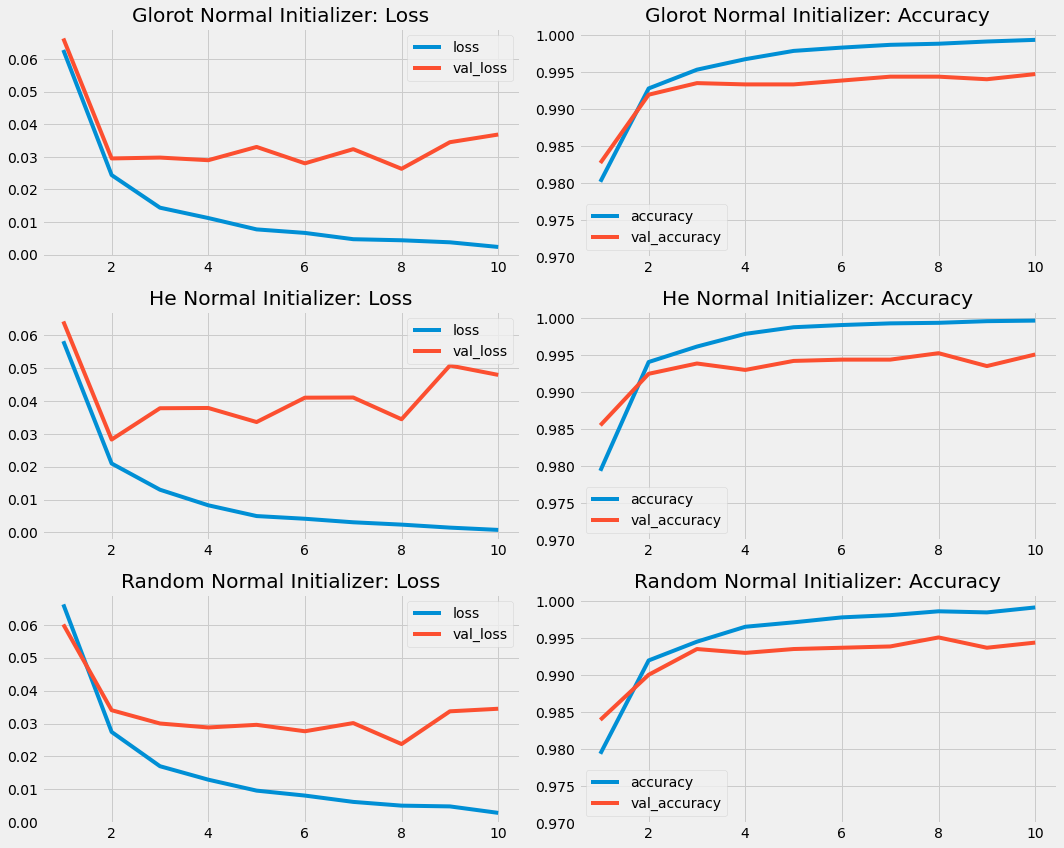

In [26]:
fig, axes = plt.subplots(3, 2, figsize = (15, 12))
y_lim = [0.97, 1.001]
glorot_normal_df[["loss", "val_loss"]].plot.line(title='Glorot Normal Initializer: Loss', ax=axes[0,0])
glorot_normal_df[["accuracy", "val_accuracy"]].plot.line(title='Glorot Normal Initializer: Accuracy', ax=axes[0,1], ylim=y_lim)

he_normal_df[["loss", "val_loss"]].plot.line(title='He Normal Initializer: Loss', ax=axes[1,0])
he_normal_df[["accuracy", "val_accuracy"]].plot.line(title='He Normal Initializer: Accuracy', ax=axes[1,1], ylim=y_lim)

random_normal_df[["loss", "val_loss"]].plot.line(title='Random Normal Initializer: Loss', ax=axes[2,0])
random_normal_df[["accuracy", "val_accuracy"]].plot.line(title='Random Normal Initializer: Accuracy', ax=axes[2,1], ylim=y_lim)

plt.tight_layout()
plt.show()

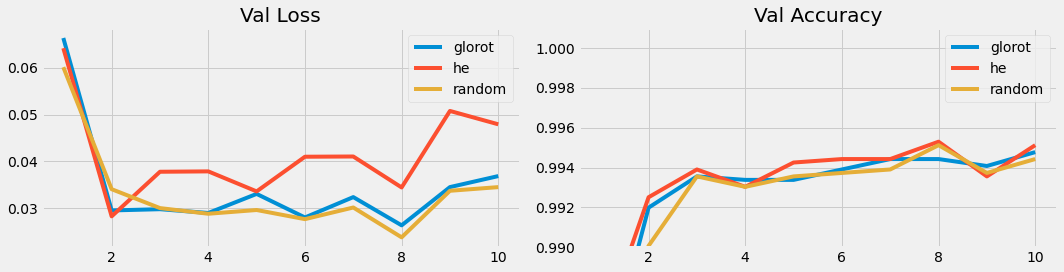

In [27]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
y_lim = [0.99, 1.001]

initializer_val_loss = pd.DataFrame({
    'glorot':glorot_normal_df['val_loss'],
    'he':he_normal_df['val_loss'],
    'random':random_normal_df['val_loss']
})
initializer_val_loss.plot.line(title='Val Loss', ax=axes[0])

initializer_val_accuracy = pd.DataFrame({
    'glorot':glorot_normal_df['val_accuracy'],
    'he':he_normal_df['val_accuracy'],
    'random':random_normal_df['val_accuracy']
})
initializer_val_accuracy.plot.line(title='Val Accuracy', ax=axes[1], ylim=y_lim)

plt.legend()
plt.tight_layout()
plt.show()

##**STEP 7 : ACTIVATION FUNCTION**

In [28]:
activation_func_history = {}

###**ReLU Activation Function**

In [29]:
tf.keras.backend.clear_session()
np.random.seed(77)
tf.random.set_seed(77)

In [30]:
relu_model = lenet_network(weight_init=initializers.RandomNormal(), conv_act_func='relu')

relu_model.compile(
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

relu_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 64)                346176    
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 346,691
Trainable params: 346,691
Non-trainable params: 0
__________________________________________________

In [31]:
activation_func_history['ReLU'] = relu_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10).history

Epoch 1/10
419/419 [==============================] - 10s 22ms/step - loss: 0.0662 - accuracy: 0.9794 - val_loss: 0.0601 - val_accuracy: 0.9840
Epoch 2/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0274 - accuracy: 0.9920 - val_loss: 0.0341 - val_accuracy: 0.9901
Epoch 3/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0170 - accuracy: 0.9946 - val_loss: 0.0300 - val_accuracy: 0.9936
Epoch 4/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0129 - accuracy: 0.9966 - val_loss: 0.0288 - val_accuracy: 0.9930
Epoch 5/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0096 - accuracy: 0.9972 - val_loss: 0.0296 - val_accuracy: 0.9936
Epoch 6/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.0277 - val_accuracy: 0.9937
Epoch 7/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.0302 - val_accuracy: 0.993

###**Sigmoid Activation Function**

In [32]:
tf.keras.backend.clear_session()
np.random.seed(77)
tf.random.set_seed(77)

In [33]:
sigmoid_model = lenet_network(weight_init=initializers.RandomNormal(), conv_act_func='sigmoid')

sigmoid_model.compile(
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

sigmoid_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 64)                346176    
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 346,691
Trainable params: 346,691
Non-trainable params: 0
__________________________________________________

In [34]:
activation_func_history['Sigmoid'] = sigmoid_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10).history

Epoch 1/10
419/419 [==============================] - 10s 22ms/step - loss: 0.9651 - accuracy: 0.5776 - val_loss: 0.5126 - val_accuracy: 0.7476
Epoch 2/10
419/419 [==============================] - 9s 21ms/step - loss: 0.1537 - accuracy: 0.9522 - val_loss: 0.1300 - val_accuracy: 0.9542
Epoch 3/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0937 - accuracy: 0.9707 - val_loss: 0.0951 - val_accuracy: 0.9695
Epoch 4/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0816 - accuracy: 0.9754 - val_loss: 0.0643 - val_accuracy: 0.9800
Epoch 5/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0733 - accuracy: 0.9768 - val_loss: 0.0937 - val_accuracy: 0.9730
Epoch 6/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0673 - accuracy: 0.9789 - val_loss: 0.1565 - val_accuracy: 0.9453
Epoch 7/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0627 - accuracy: 0.9810 - val_loss: 0.0540 - val_accuracy: 0.984

## **STEP 8 : ACTIVATION ANALYSIS**

In [35]:
for model_name, model_history in activation_func_history.items():
    df_name = str(model_name.replace(' ', '_').lower()) + "_df"
    locals()[df_name] = pd.DataFrame(model_history, index = (range(1,11)))

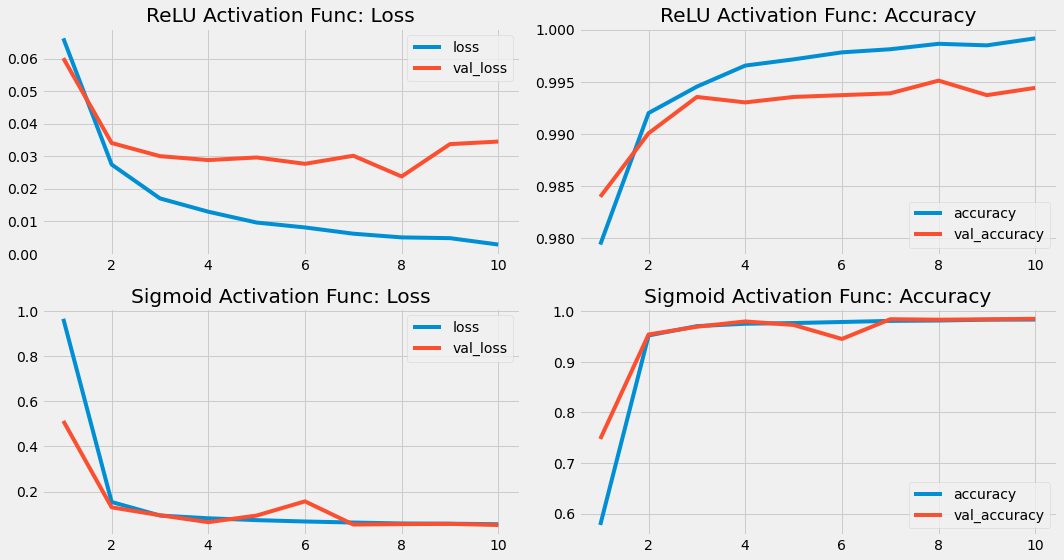

In [36]:
fig, axes = plt.subplots(2, 2, figsize = (15, 8))

relu_df[["loss", "val_loss"]].plot.line(title='ReLU Activation Func: Loss', ax=axes[0,0])
relu_df[["accuracy", "val_accuracy"]].plot.line(title='ReLU Activation Func: Accuracy', ax=axes[0,1])

sigmoid_df[["loss", "val_loss"]].plot.line(title='Sigmoid Activation Func: Loss', ax=axes[1,0])
sigmoid_df[["accuracy", "val_accuracy"]].plot.line(title='Sigmoid Activation Func: Accuracy', ax=axes[1,1])

plt.tight_layout()
plt.show()

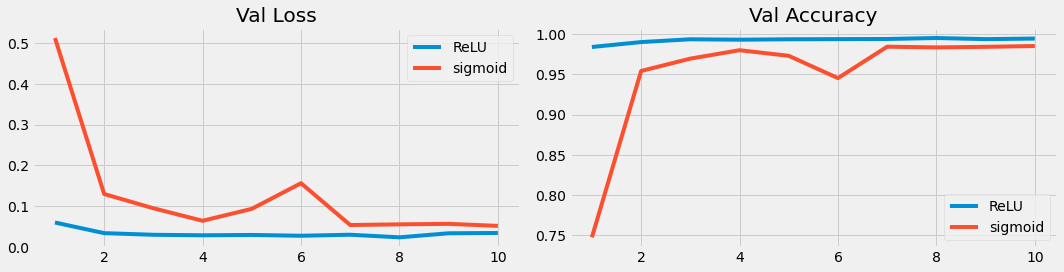

In [37]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

activation_func_val_loss = pd.DataFrame({
    'ReLU':relu_df['val_loss'],
    'sigmoid':sigmoid_df['val_loss'],
})
activation_func_val_loss.plot.line(title='Val Loss', ax=axes[0])

activation_func_val_accuracy = pd.DataFrame({
    'ReLU':relu_df['val_accuracy'],
    'sigmoid':sigmoid_df['val_accuracy'],
})
activation_func_val_accuracy.plot.line(title='Val Accuracy', ax=axes[1])

plt.legend()
plt.tight_layout()
plt.show()

##**STEP 9 : OPTIMIZER**

In [38]:
optimizer_history = {}

### **SGD nestervov**

In [39]:
tf.keras.backend.clear_session()
np.random.seed(77)
tf.random.set_seed(77)

In [40]:
sgd_nesterov_model = lenet_network(weight_init=initializers.RandomNormal(), conv_act_func='relu')

sgd_nesterov_model.compile(
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"],
    optimizer = optimizers.SGD(
        nesterov=True, name='SGD'
    )
)

sgd_nesterov_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 64)                346176    
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 346,691
Trainable params: 346,691
Non-trainable params: 0
__________________________________________________

In [41]:
optimizer_history['SGD nesterov'] = sgd_nesterov_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10).history

Epoch 1/10
419/419 [==============================] - 9s 20ms/step - loss: 0.2414 - accuracy: 0.9510 - val_loss: 0.0880 - val_accuracy: 0.9727
Epoch 2/10
419/419 [==============================] - 8s 19ms/step - loss: 0.0744 - accuracy: 0.9761 - val_loss: 0.0703 - val_accuracy: 0.9761
Epoch 3/10
419/419 [==============================] - 8s 20ms/step - loss: 0.0614 - accuracy: 0.9806 - val_loss: 0.0628 - val_accuracy: 0.9791
Epoch 4/10
419/419 [==============================] - 8s 19ms/step - loss: 0.0542 - accuracy: 0.9835 - val_loss: 0.0589 - val_accuracy: 0.9817
Epoch 5/10
419/419 [==============================] - 8s 20ms/step - loss: 0.0494 - accuracy: 0.9853 - val_loss: 0.0547 - val_accuracy: 0.9822
Epoch 6/10
419/419 [==============================] - 8s 19ms/step - loss: 0.0457 - accuracy: 0.9855 - val_loss: 0.0510 - val_accuracy: 0.9833
Epoch 7/10
419/419 [==============================] - 8s 19ms/step - loss: 0.0424 - accuracy: 0.9869 - val_loss: 0.0492 - val_accuracy: 0.9835

### **Adam**

In [42]:
tf.keras.backend.clear_session()
np.random.seed(77)
tf.random.set_seed(77)

In [43]:
adam_model = lenet_network(weight_init=initializers.RandomNormal(), conv_act_func='relu')

adam_model.compile(
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"],
    optimizer = optimizers.Adam(
        name='Adam'
    )
)

adam_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 64)                346176    
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 346,691
Trainable params: 346,691
Non-trainable params: 0
__________________________________________________

In [44]:
optimizer_history['Adam'] = adam_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10).history

Epoch 1/10
419/419 [==============================] - 9s 20ms/step - loss: 0.0728 - accuracy: 0.9797 - val_loss: 0.0343 - val_accuracy: 0.9897
Epoch 2/10
419/419 [==============================] - 8s 20ms/step - loss: 0.0225 - accuracy: 0.9934 - val_loss: 0.0267 - val_accuracy: 0.9927
Epoch 3/10
419/419 [==============================] - 8s 19ms/step - loss: 0.0138 - accuracy: 0.9963 - val_loss: 0.0271 - val_accuracy: 0.9923
Epoch 4/10
419/419 [==============================] - 8s 20ms/step - loss: 0.0089 - accuracy: 0.9972 - val_loss: 0.0199 - val_accuracy: 0.9936
Epoch 5/10
419/419 [==============================] - 8s 20ms/step - loss: 0.0049 - accuracy: 0.9989 - val_loss: 0.0231 - val_accuracy: 0.9937
Epoch 6/10
419/419 [==============================] - 8s 20ms/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.0217 - val_accuracy: 0.9941
Epoch 7/10
419/419 [==============================] - 8s 20ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.0256 - val_accuracy: 0.9939

### **RMSprop**

In [45]:
tf.keras.backend.clear_session()
np.random.seed(77)
tf.random.set_seed(77)

In [46]:
rmsprop_model = lenet_network(weight_init=initializers.RandomNormal(), conv_act_func='relu')

rmsprop_model.compile(
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"],
    optimizer = optimizers.RMSprop(
        name='RMSprop'
    )
)

rmsprop_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 64)                346176    
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 346,691
Trainable params: 346,691
Non-trainable params: 0
__________________________________________________

In [47]:
optimizer_history['RMSprop'] = rmsprop_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10).history

Epoch 1/10
419/419 [==============================] - 10s 21ms/step - loss: 0.0662 - accuracy: 0.9794 - val_loss: 0.0601 - val_accuracy: 0.9840
Epoch 2/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0274 - accuracy: 0.9920 - val_loss: 0.0341 - val_accuracy: 0.9901
Epoch 3/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0170 - accuracy: 0.9946 - val_loss: 0.0300 - val_accuracy: 0.9936
Epoch 4/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0129 - accuracy: 0.9966 - val_loss: 0.0288 - val_accuracy: 0.9930
Epoch 5/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0096 - accuracy: 0.9972 - val_loss: 0.0296 - val_accuracy: 0.9936
Epoch 6/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.0277 - val_accuracy: 0.9937
Epoch 7/10
419/419 [==============================] - 9s 21ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.0302 - val_accuracy: 0.993

##**STEP 10 : OPTIMIZER ANALYSIS**

In [48]:
for model_name, model_history in optimizer_history.items():
    df_name = str(model_name.replace(' ', '_').lower()) + "_df"
    locals()[df_name] = pd.DataFrame(model_history, index = (range(1,11)))

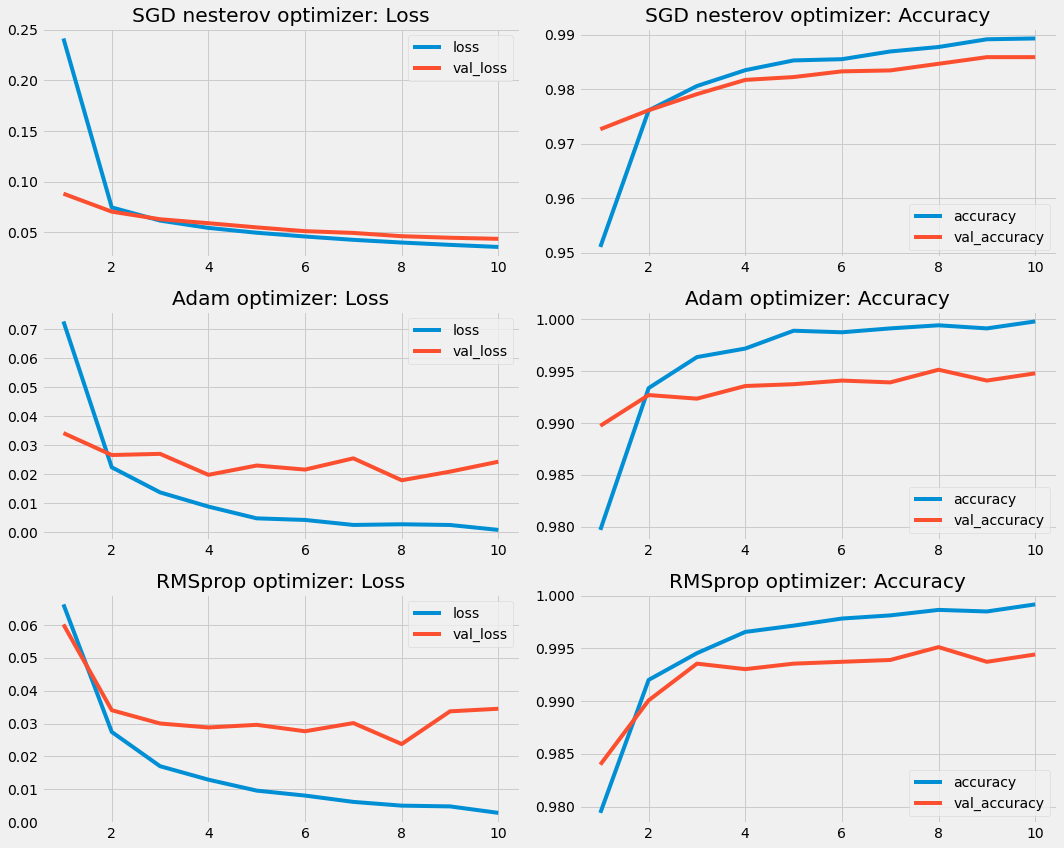

In [49]:
fig, axes = plt.subplots(3, 2, figsize = (15, 12))

sgd_nesterov_df[["loss", "val_loss"]].plot.line(title='SGD nesterov optimizer: Loss', ax=axes[0,0])
sgd_nesterov_df[["accuracy", "val_accuracy"]].plot.line(title='SGD nesterov optimizer: Accuracy', ax=axes[0,1])

adam_df[["loss", "val_loss"]].plot.line(title='Adam optimizer: Loss', ax=axes[1,0])
adam_df[["accuracy", "val_accuracy"]].plot.line(title='Adam optimizer: Accuracy', ax=axes[1,1])

rmsprop_df[["loss", "val_loss"]].plot.line(title='RMSprop optimizer: Loss', ax=axes[2,0])
rmsprop_df[["accuracy", "val_accuracy"]].plot.line(title='RMSprop optimizer: Accuracy', ax=axes[2,1])

plt.tight_layout()
plt.show()

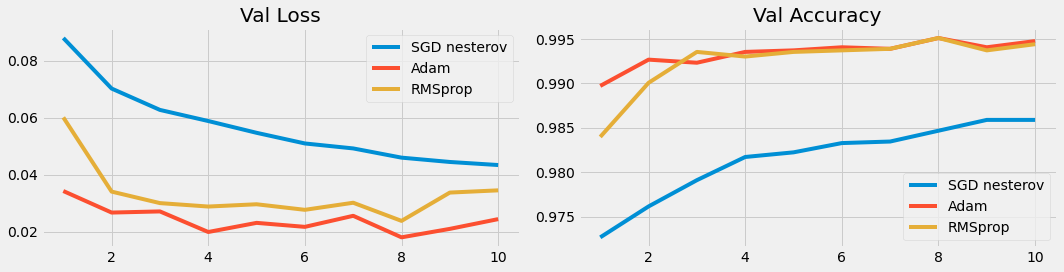

In [50]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

optimizer_val_loss = pd.DataFrame({
    'SGD nesterov':sgd_nesterov_df['val_loss'],
    'Adam':adam_df['val_loss'],
    'RMSprop':rmsprop_df['val_loss'],
})
optimizer_val_loss.plot.line(title='Val Loss', ax=axes[0])

optimizer_val_accuracy = pd.DataFrame({
    'SGD nesterov':sgd_nesterov_df['val_accuracy'],
    'Adam':adam_df['val_accuracy'],
    'RMSprop':rmsprop_df['val_accuracy'],
})
optimizer_val_accuracy.plot.line(title='Val Accuracy', ax=axes[1])

plt.legend()
plt.tight_layout()
plt.show()

##**STEP 11 : HYPERPARAMETER TUNING**

### **SGD nestervov**

In [51]:
tf.keras.backend.clear_session()
np.random.seed(77)
tf.random.set_seed(77)

In [52]:
def lenet_network_sgd_tuning(hp):
    
    model = Sequential([
        Conv2D(32, [3, 3], activation='relu', kernel_initializer=initializers.RandomNormal(), input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size = (2, 2)),
        Flatten(),
        Dense(units=64, activation='relu', kernel_initializer=initializers.RandomNormal()),
        Dense(3, activation='softmax')
    ])
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
    optimizer = optimizers.SGD(
        nesterov=True, learning_rate=hp_learning_rate, name='SGD'
    )
    model.compile(
        loss = "sparse_categorical_crossentropy",
        metrics = ["accuracy"],
        optimizer = optimizer
    )
    
    return model

In [53]:
tuner_sgd = kt.Hyperband(
    lenet_network_sgd_tuning, objective='val_accuracy', directory='my_dir', project_name='sgd', max_epochs=10
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [54]:
tuner_sgd.search(X_train, y_train, validation_data = (X_val, y_val), epochs=20, callbacks=[stop_early])

Trial 5 Complete [00h 00m 17s]
val_accuracy: 0.9552420973777771

Best val_accuracy So Far: 0.9848484992980957
Total elapsed time: 00h 01m 33s
INFO:tensorflow:Oracle triggered exit


In [55]:
# Get the optimal hyperparameters
best_hps_sgd=tuner_sgd.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for SGD optimizer is {best_hps_sgd.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal learning rate for SGD optimizer is 0.1.



### **ADAM**

In [56]:
tf.keras.backend.clear_session()
np.random.seed(77)
tf.random.set_seed(77)

In [57]:
def lenet_network_adam_tuning(hp):
    
    model = Sequential([
        Conv2D(32, [3, 3], activation='relu', kernel_initializer=initializers.RandomNormal(), input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size = (2, 2)),
        Flatten(),
        Dense(units=64, activation='relu', kernel_initializer=initializers.RandomNormal()),
        Dense(3, activation='softmax')
    ])
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
    optimizer = optimizers.Adam(
        learning_rate=hp_learning_rate, name='Adam'
    )
    model.compile(
        loss = "sparse_categorical_crossentropy",
        metrics = ["accuracy"],
        optimizer = optimizer
    )
    
    return model

In [58]:
tuner_adam = kt.Hyperband(
    lenet_network_adam_tuning, objective='val_accuracy', directory='my_dir', project_name='adam', max_epochs=10
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [59]:
tuner_adam.search(X_train, y_train, validation_data = (X_val, y_val), epochs=20, callbacks=[stop_early])

Trial 5 Complete [00h 00m 17s]
val_accuracy: 0.9622082710266113

Best val_accuracy So Far: 0.9926854968070984
Total elapsed time: 00h 01m 38s
INFO:tensorflow:Oracle triggered exit


In [60]:
# Get the optimal hyperparameters
best_hps_adam=tuner_adam.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for Adam optimizer is {best_hps_adam.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal learning rate for Adam optimizer is 0.001.



### **RMSProp**

In [61]:
tf.keras.backend.clear_session()
np.random.seed(77)
tf.random.set_seed(77)

In [62]:
def lenet_network_rmsprop_tuning(hp):
    
    model = Sequential([
        Conv2D(32, [3, 3], activation='relu', kernel_initializer=initializers.RandomNormal(), input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size = (2, 2)),
        Flatten(),
        Dense(units=64, activation='relu', kernel_initializer=initializers.RandomNormal()),
        Dense(3, activation='softmax')
    ])
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
    optimizer = optimizers.RMSprop(
        learning_rate=hp_learning_rate, name='RMSprop'
    )
    model.compile(
        loss = "sparse_categorical_crossentropy",
        metrics = ["accuracy"],
        optimizer = optimizer
    )
    
    return model

In [63]:
tuner_rmsprop = kt.Hyperband(
    lenet_network_rmsprop_tuning, objective='val_accuracy', directory='my_dir', project_name='rmsprop', max_epochs=10
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [64]:
tuner_rmsprop.search(X_train, y_train, validation_data = (X_val, y_val), epochs=20, callbacks=[stop_early])

Trial 5 Complete [00h 00m 21s]
val_accuracy: 0.9886798858642578

Best val_accuracy So Far: 0.9897248148918152
Total elapsed time: 00h 01m 37s
INFO:tensorflow:Oracle triggered exit


In [65]:
# Get the optimal hyperparameters
best_hps_rmsprop=tuner_rmsprop.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for RMSprop optimizer is {best_hps_rmsprop.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal learning rate for RMSprop optimizer is 0.001.



## **STEP 12 : CONCLUSION FULL TRAIN**

In [66]:
np.random.seed(77)
tf.random.set_seed(77)
tf.keras.backend.clear_session()

In [67]:
final_model = tuner_rmsprop.hypermodel.build(best_hps_rmsprop)

In [68]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [69]:
final_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks=[stop_early])

Epoch 1/100
419/419 [==============================] - 10s 22ms/step - loss: 0.0662 - accuracy: 0.9794 - val_loss: 0.0601 - val_accuracy: 0.9840
Epoch 2/100
419/419 [==============================] - 9s 21ms/step - loss: 0.0274 - accuracy: 0.9920 - val_loss: 0.0341 - val_accuracy: 0.9901
Epoch 3/100
419/419 [==============================] - 9s 21ms/step - loss: 0.0170 - accuracy: 0.9946 - val_loss: 0.0300 - val_accuracy: 0.9936
Epoch 4/100
419/419 [==============================] - 9s 21ms/step - loss: 0.0129 - accuracy: 0.9966 - val_loss: 0.0288 - val_accuracy: 0.9930
Epoch 5/100
419/419 [==============================] - 9s 21ms/step - loss: 0.0096 - accuracy: 0.9972 - val_loss: 0.0296 - val_accuracy: 0.9936
Epoch 6/100
419/419 [==============================] - 9s 21ms/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.0277 - val_accuracy: 0.9937
Epoch 7/100
419/419 [==============================] - 9s 21ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.0302 - val_accuracy

In [79]:
final_model_history = pd.DataFrame(final_model.history.history)

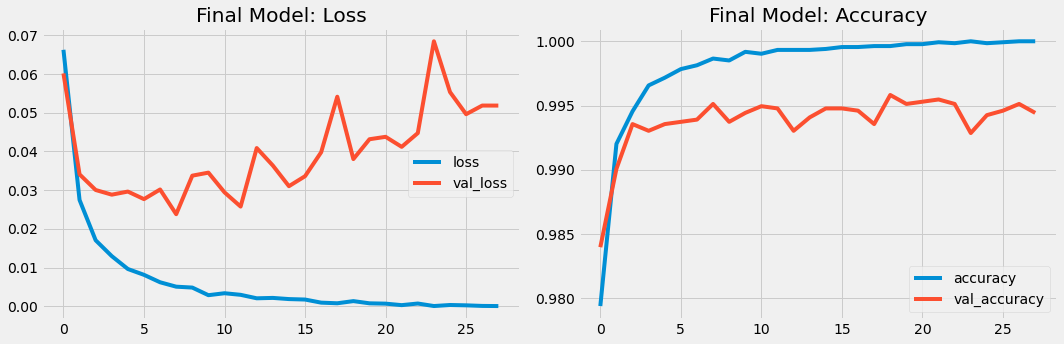

In [80]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
final_model_history[["loss", "val_loss"]].plot.line(title='Final Model: Loss', ax=axes[0])
final_model_history[["accuracy", "val_accuracy"]].plot.line(title='Final Model: Accuracy', ax=axes[1])

plt.tight_layout()
plt.show()

### **X_test**

In [81]:
y_proba = final_model.predict(X_test)
y_pred = np.argmax(y_proba, axis=-1)

In [82]:
confusion_matrix(y_test, y_pred)

array([[1134,    1,    0],
       [   0, 1006,    4],
       [   5,    3, 1020]])

In [83]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.996     0.999     0.997      1135
         1.0      0.996     0.996     0.996      1010
         2.0      0.996     0.992     0.994      1028

    accuracy                          0.996      3173
   macro avg      0.996     0.996     0.996      3173
weighted avg      0.996     0.996     0.996      3173



In [84]:
class_0 = np.where(y_test == 0.0, 1.0, 0.0)
class_1 = np.where(y_test == 1.0, 1.0, 0.0)
class_2 = np.where(y_test == 2.0, 1.0, 0.0)

pred_class_0 = np.where(y_pred == 0.0, 1.0, 0.0)
pred_class_1 = np.where(y_pred == 1.0, 1.0, 0.0)
pred_class_2 = np.where(y_pred == 2.0, 1.0, 0.0)

### **ROC AUC score (One vs Rest)**

In [85]:
print(f"Class 0 (Image of 1): {round(roc_auc_score(class_0, pred_class_0), 4)}")
print(f"Class 1 (Image of 3): {round(roc_auc_score(class_1, pred_class_1), 4)}")
print(f"Class 2 (Image of 7): {round(roc_auc_score(class_2, pred_class_2), 4)}")

Class 0 (Image of 1): 0.9983
Class 1 (Image of 3): 0.9971
Class 2 (Image of 7): 0.9952
